In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

# Protein levels - unsupervised analyses

Please refer to [Protein_data_QC_and_transforms](Protein_data_QC_and_transforms.ipynb) for introduction to SOMAscan, introductory discussion on transformations and data quality checks.

In [2]:
protein_path = 'data/clean/protein/indexed_by_target.csv'
zz_log_path = 'data/clean/protein/zz_log_10.csv'
log_matrix_path = 'data/clean/protein/log_10.csv'

clinical_path = 'data/clean/clinical/data.csv'
aptamers_path = 'data/other/relevant_aptamers.csv'

uniprot_to_go_path = 'data/ontologies/goa_human.gaf'
gene_ontology_path = 'data/ontologies/go-basic.obo'

In [3]:
matrix = read_csv(protein_path, index_col=[0])

## Clustering

In [4]:
clinical_data = read_csv(clinical_path, index_col=0)

In [5]:
clinical_for_protein_study = clinical_data.loc[matrix.columns]

In [6]:
clinical_ordered = clinical_for_protein_study.loc[matrix.columns]
set(clinical_ordered.condition)

{'CM', 'HC', 'TMD', 'TMR', 'TMS', 'VM'}

#### For easy interpretation of patient clusters:

In [7]:
from plots.annotations import conditions_names, tuberculosis_status, generate_patient_annotations

In [8]:
patient_annotations = generate_patient_annotations(clinical_ordered)

In [9]:
%R source('plots/colors.R');

In [10]:
%%R -i matrix -i patient_annotations
library(pheatmap)

colnames(matrix) <- sub('^X', '', colnames(matrix))
rownames(patient_annotations) <- colnames(matrix)
names(patient_annotations) <- sub('\\.', ' ', names(patient_annotations))

### First look at the data

Simple clustering with log10-transformation and defaults (linkage=complete, distance=euclidean) to get an overview of the data:

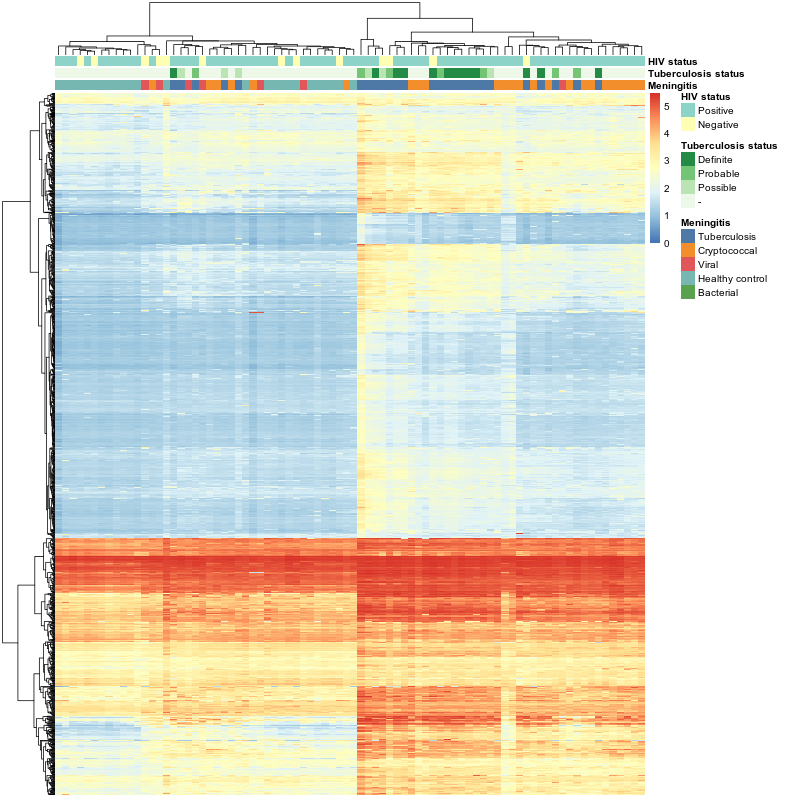

In [11]:
%%R -w 800 -h 800 -u px
pheatmap(
    log10(matrix),
    show_colnames=FALSE,
    show_rownames=FALSE,
    annotation_col=patient_annotations,
    annotation_colors=patient_colors
)

Z-score, protein-wise (log10 transform skipped on purpose):

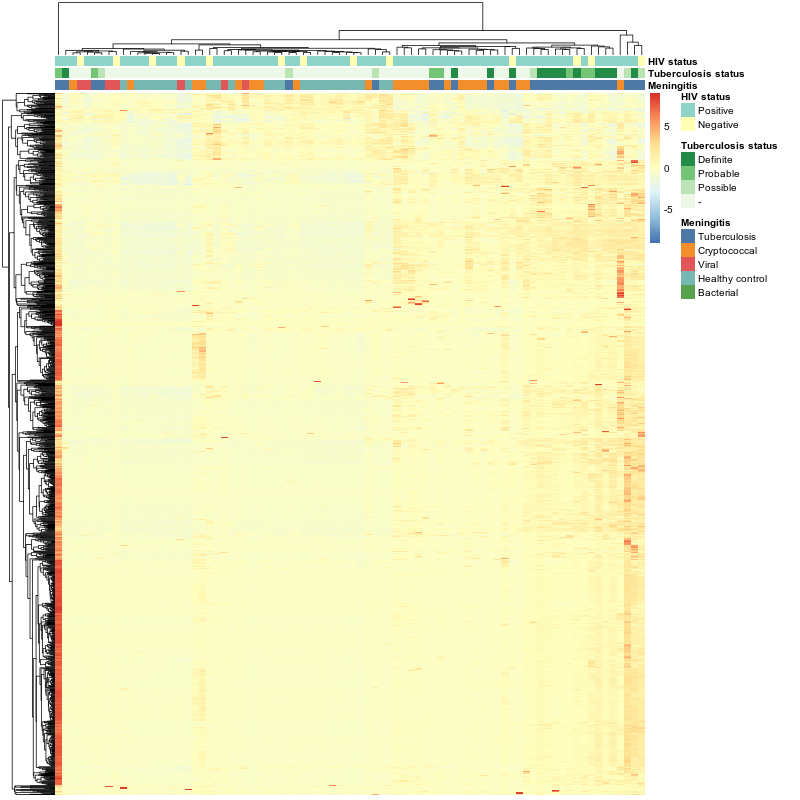

In [12]:
%%R -w 800 -h 800 -u px
pheatmap(
    matrix,
    show_colnames=FALSE,
    show_rownames=FALSE,
    annotation_col=patient_annotations,
    annotation_colors=patient_colors,
    scale='row' # this enables z-score, row-wise
)

Regardless of transformation:
- The clustering looks nice! Many tuberculosis patients are in the same cluster, similarly the cryptococcal patients. There is some overlap.
- No clear clustering by HIV status

Log-10 transformation highlights:
- Seems to place all the healthy controls on the left cluster and most of the meningitis patients to the right cluster.  

The z-score transformation highlights that:
- One patient is an outlier, with values much higher than average for most genes.

The outlier patient is:

In [13]:
matrix.mean().idxmax()

'024.TMR'

### Choosing linkage method and distance

- Definitely not "single" linkage, prefer "complete" over "average" [(D'haeseleer, 2005)](https://www.nature.com/articles/nbt1205-1499)
- Ward linkage and Pearson correlation distance may be better for proteomics data [(Meunier, 2007)](https://pubs.acs.org/doi/full/10.1021/pr060343h)

My intuition for the distance function choice:
- Pearson correlation will tend to group together patients with similar patterns of relative protein abundances
- Euclidean distance will tend to group together patients with similar levels of proteins, giving less weight to the distribution patterns

Thus correlation may "correct" for the technical variation in samples.

NB: there is some discussion regarding the use of distance measures other than euclidean for ward's method. Revisit later?

I will continue to use log transformation (as explored in [Transformation_and_normalization.ipynb](Transformation_and_normalization.ipynb) notebook):

In [14]:
log_matrix = read_csv(log_matrix_path, index_col=0)

But will refrain from any further transformations for now.

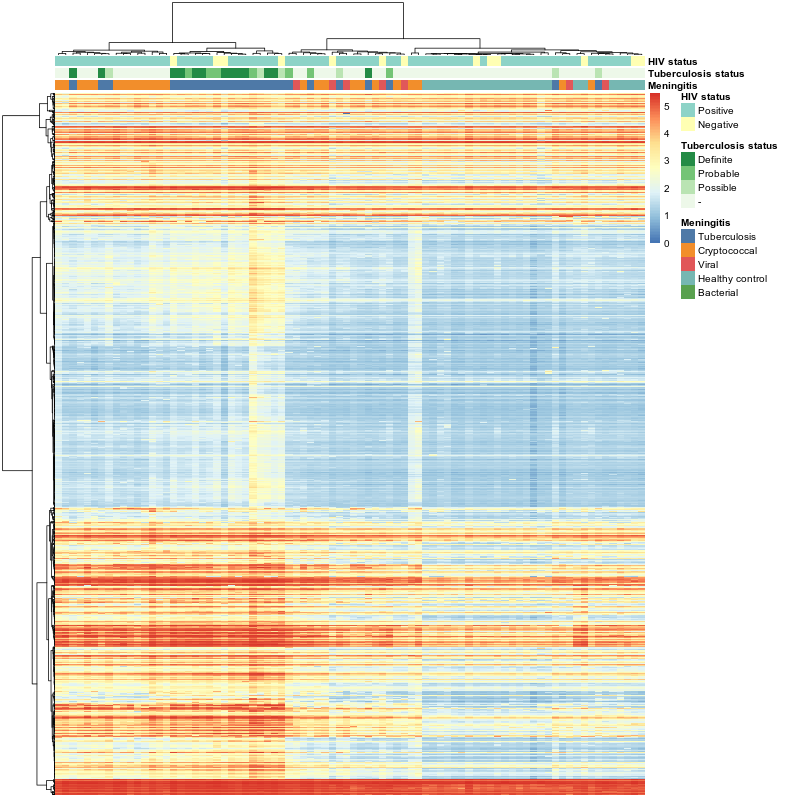

In [15]:
%%R -w 800 -h 800 -u px -i log_matrix -o log_clusters
colnames(log_matrix) <- sub('^X', '', colnames(log_matrix))

log_clusters = pheatmap(
    log_matrix,
    show_colnames=FALSE,
    show_rownames=FALSE,
    annotation_col=patient_annotations,
    annotation_colors=patient_colors,
    scale='none',
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation'
)

### Further attempts to normalize/transform

To compare robustness of the results retrieved above and to study the need to further normalization I will use a double z-score transformation approach (first on patients than on proteins), as outlined in the [Transformation_and_QC.ipynb](Transformation_and_QC.ipynb) notebook:

In [16]:
zz_log_matrix = read_csv(zz_log_path, index_col=0)

Note: after such transformation, the per-patient variance is not equal to one (though it is alleviated by centering and scaling again in the PCA procedure and by use of correlation distance in HCA).

In [17]:
from helpers import z_score

In [18]:
variance_by_patient = log_matrix.apply(z_score).apply(z_score, axis=1).var().reset_index()
variance_by_patient.columns = ['patient', 'variance']

In [19]:
df = variance_by_patient.merge(patient_annotations, left_on='patient', right_index=True)

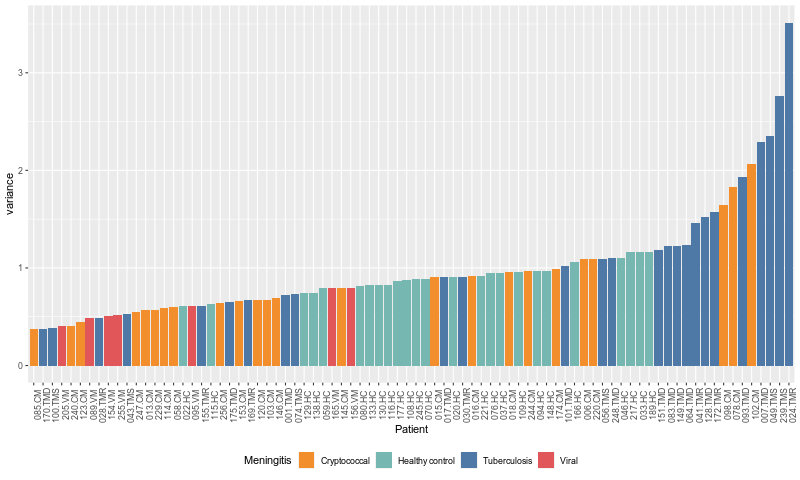

In [20]:
%%R -i df -w 800 -u px
(
    ggplot(df, aes(x=reorder(patient, variance), y=variance, fill=Meningitis))
    + geom_bar(stat='identity')
    + scale_fill_manual(values=patient_colors$Meningitis)
    + theme(axis.text.x=element_text(angle=90), legend.position='bottom')
    + xlab('Patient')
)

While z-score transformation of one axis (patients/proteins) would not change the clustering when the distance function is correlation, it is not true for clustering on the other axis (as it is not centered/scaled, see the picture above). Thus z-transformation may change the clustering results.

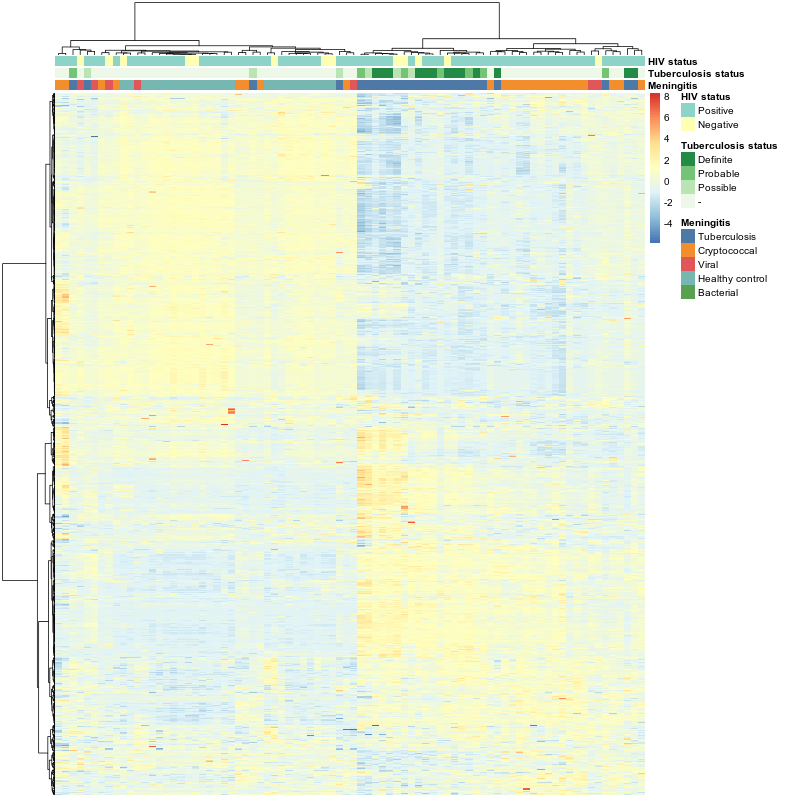

In [21]:
%%R -w 800 -h 800 -u px -i zz_log_matrix -o zz_log_clusters
colnames(zz_log_matrix) <- sub('^X', '', colnames(zz_log_matrix))

zz_log_clusters = pheatmap(
    zz_log_matrix,
    show_colnames=FALSE,
    show_rownames=FALSE,
    annotation_col=patient_annotations,
    annotation_colors=patient_colors,
    scale='none',
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation'
)

As the patient clustering is visibly good enough as for the initial analysis, I will stop here.

An alternative would be to explore top-bottom clustering as an addition.

### Analysis - patient clustering

In [22]:
%%R
library('factoextra');

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


In [23]:
%%R
# these are simply hclust results
log_patient_clusters = log_clusters$tree_col
zz_log_patient_clusters = zz_log_clusters$tree_col

#### Log-transformed

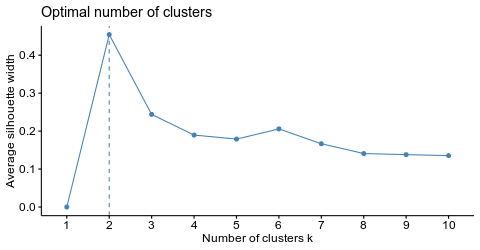

In [24]:
%%R -h 250 -u px
fviz_nbclust(
    t(log_matrix), # transpose to cluster patients, not proteins
    hcut, method='silhouette', hc_metric='pearson', hc_method='ward.D2'
)

I will ignore the suggestion of selecting two clusters - we know that there are at least four distinct patient groups. I do not show plots for elbow method/RSS as these have the same issue.

I will choose $k=6$ for the log-transformed clustering as there is a visible drop at $k=$ (and we want $k>=4$).

In [25]:
%%R
log_subgroups = cutree(log_patient_clusters, 6)

Simple PCA visualization:

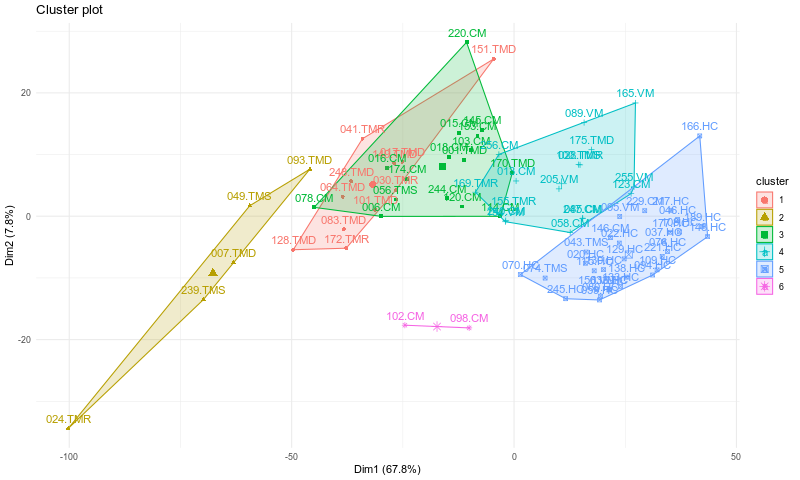

In [26]:
%%R -w 800 -u px
fviz_cluster(list(data=t(log_matrix), cluster=log_subgroups)) + theme_minimal()

Well, the data was not normalized.

#### Log-z-transformed "normalized"

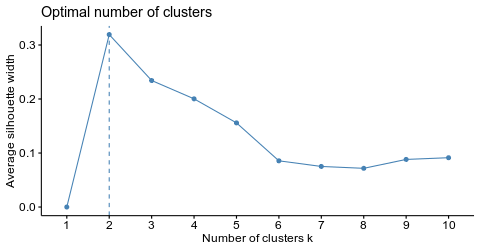

In [27]:
%%R -h 250 -u px
fviz_nbclust(t(zz_log_matrix), hcut, method='silhouette', hc_metric='pearson', hc_method='ward.D2')

I will choose $k = 4$ as it is the minimal assumed number of clusters.

In [28]:
%%R
zz_log_subgroups = cutree(zz_log_patient_clusters, 4)

Simple PCA

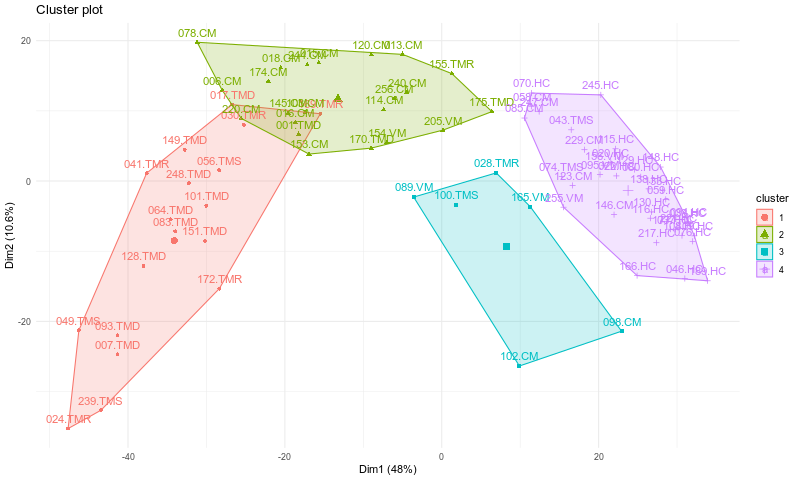

In [29]:
%%R -w 800 -u px
fviz_cluster(list(data=t(zz_log_matrix), cluster=zz_log_subgroups)) + theme_minimal()

#### Z-score vs log-transform only?

In [30]:
%%R 
suppressPackageStartupMessages(library(dendextend));

The clusterings are visibly different, even after untangling:

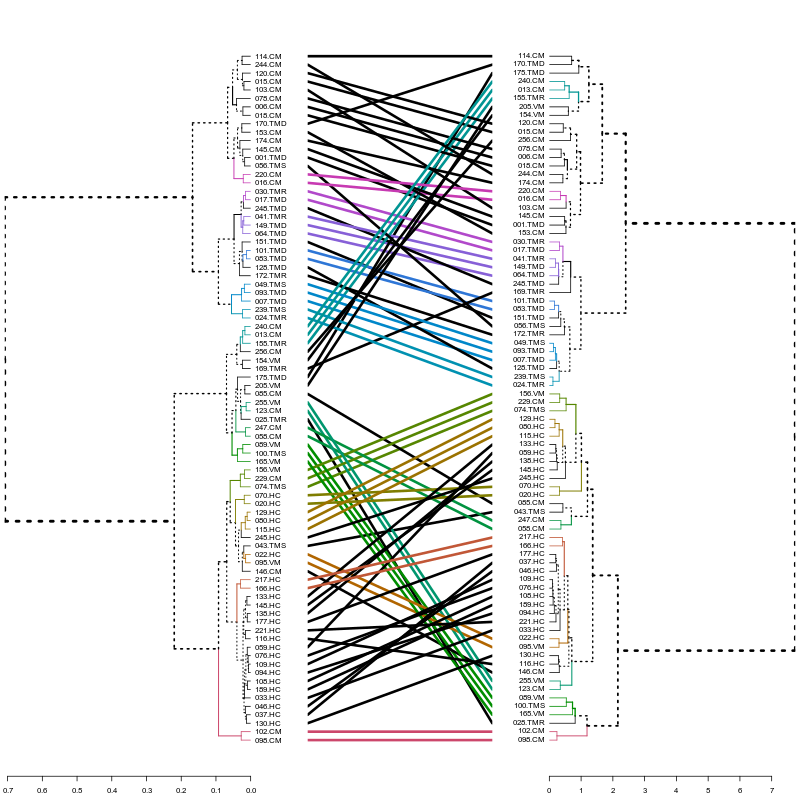

In [31]:
%%R -w 800 -h 800 -u px
patient_clusterings = dendlist(
    as.dendrogram(log_patient_clusters),
    as.dendrogram(zz_log_patient_clusters)
)

tanglegram(
    untangle(patient_clusterings, method="step1side"),
    common_subtrees_color_branches=T,
    margin_inner=6,
    highlight_distinct_edges=T,
)

### Analysis - protein clustering

In [32]:
%%R
log_protein_clusters = log_clusters$tree_row
zz_log_protein_clusters = zz_log_clusters$tree_row

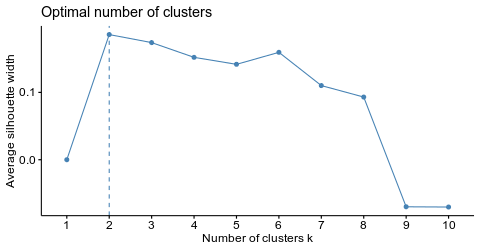

In [33]:
%%R -h 250 -u px
fviz_nbclust(log_matrix, hcut, method='silhouette', hc_metric='pearson', hc_method='ward.D2', nboot = 500)

Average silhouette is visibly lower.

Using $k=4$.

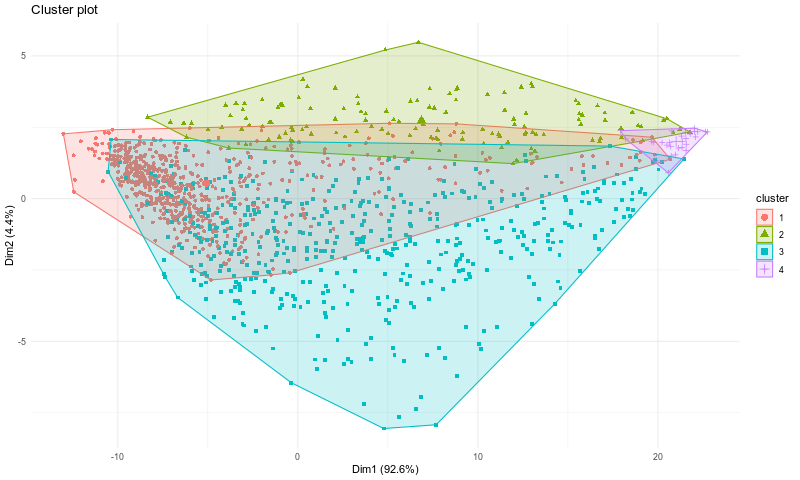

In [34]:
%%R -w 800 -u px
log_subgroups = cutree(log_protein_clusters, 4)
fviz_cluster(list(data=log_matrix, cluster=log_subgroups), geom='point') + theme_minimal()

#### Log-z-transformed "normalized"

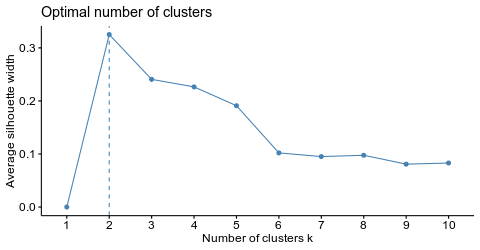

In [35]:
%%R -h 250 -u px
fviz_nbclust(zz_log_matrix, hcut, method='silhouette', hc_metric='pearson', hc_method='ward.D2')

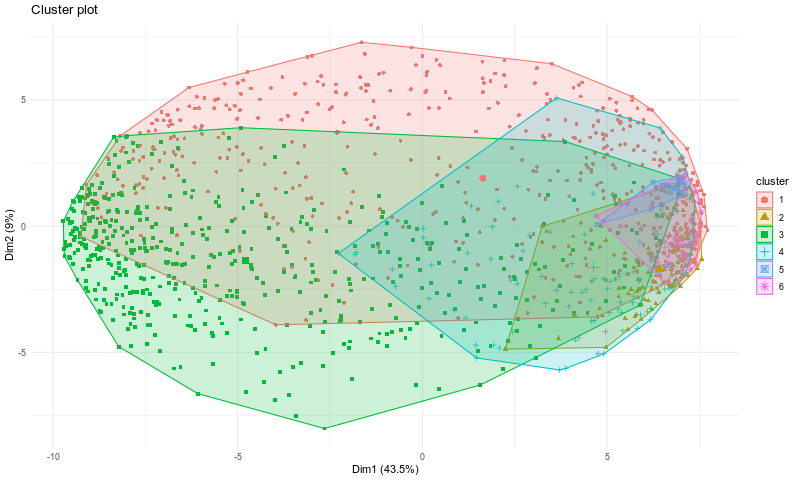

In [36]:
%%R -w 800 -u px
zz_log_subgroups = cutree(log_protein_clusters, 6)
fviz_cluster(list(data=zz_log_matrix, cluster=zz_log_subgroups), geom='point') + theme_minimal()

### Summary

TODO: Compare the clusterings with alluvial/different metrics?

### PCA

In [37]:
%%R -o pca
# scale=F would be almost* an equivalent (as I scaled the data beforehand);
# scale=T signals to the fviz package that I want to show the correlation circle
# *almost = the final transformation was z-score scaling on proteins, not patients
# (which was also performed, but earilier) so it is not an exact equivalence.
pca = prcomp(t(zz_log_matrix), scale=T)

Eigenvalues:

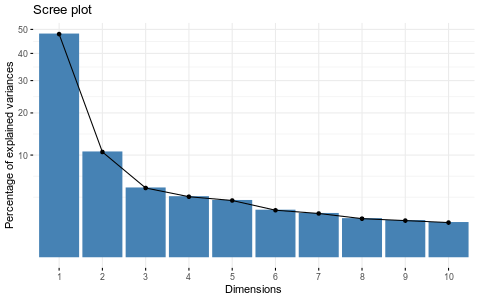

In [38]:
%%R -h 300 -u px
fviz_eig(pca) + scale_y_sqrt()

82 principal components as we have 82 patients with protein data:

In [39]:
%%R -h 300 -u px -o variance_explained_df
variance_explained_df = get_eig(pca)
variance_explained_df$PC = rownames(variance_explained_df)

In [40]:
variance_explained_df.PC = variance_explained_df.PC.str[4:] # remove the "Dim." prefix
variance_explained_df.PC = pd.Categorical(variance_explained_df.PC, ordered=True, categories=variance_explained_df.PC)

In [41]:
%R source('plots/pca.R');

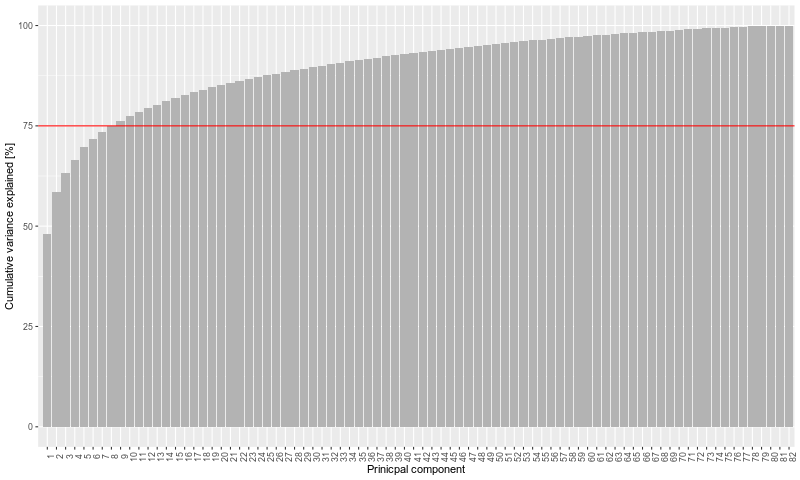

In [42]:
%%R -i variance_explained_df -w 800 -u px
cumulative_variance_explained(
    variance_explained_df,
    threshold=75 # chosen to be above >50, <100 and to get a reasonable
                 # (not too large) number of PCs to analyze
)

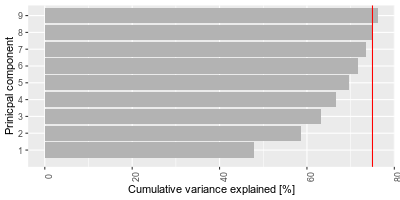

In [43]:
%%R -w 400 -h 200 -u px
(
    cumulative_variance_explained(
        variance_explained_df[variance_explained_df$PC<10,],
        threshold=75
    )
    + coord_flip()
)

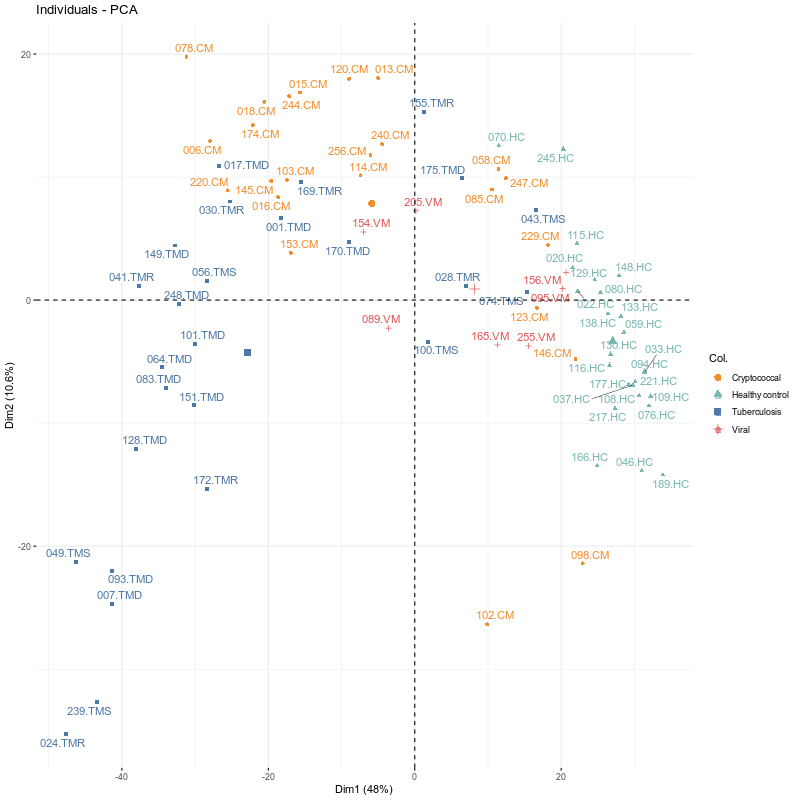

In [44]:
%%R -w 800 -h 800 -u px
fviz_pca_ind(
    pca,
    repel=T,
    col.ind=patient_annotations$Meningitis,
    palette=patient_colors$Meningitis
)

Roughly, both PC1 and PC2 separate the groups of interest:
- PC1 placing healthy controls on the right (high, positive values) and diseased patients on the left
- PC2 placing most of the cryptoccocal patients on the top (positive values) while many TB patients below

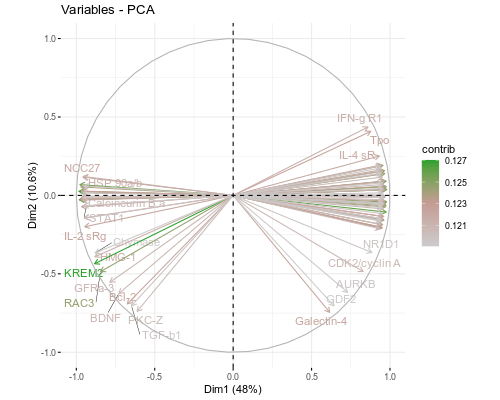

In [45]:
%%R -w 500 -h 400 -u px
fviz_pca_var(
    pca, repel=T,
    col.var="contrib",
    gradient.cols=c("#cccccc", "#c49c94", "#2CA02C"),
    select.var=list(contrib=100)
)

Selecting variables by contribution (which is scaled to the importance of a principal component) shows only the variables contributing to PC1.

To overcome this limitation and make the plot more readable, I select top 20 variables contributing the most to each of the principal components (ignoring the weighted contributions suggested by the R package):

Please see [Notes_on_PCA_with_prcomp_and_factoextra.ipynb](Notes_on_PCA_with_prcomp_and_factoextra.ipynb) for more detailed discussion.

In [46]:
from helpers.unsupervised import top_variables

In [47]:
%%R -o loadings
loadings = as.data.frame(pca$rotation)

In [48]:
selected_proteins = [
    protein
    for pc in ['PC1', 'PC2']
    for protein in top_variables(loadings, pc, n=50).index
]

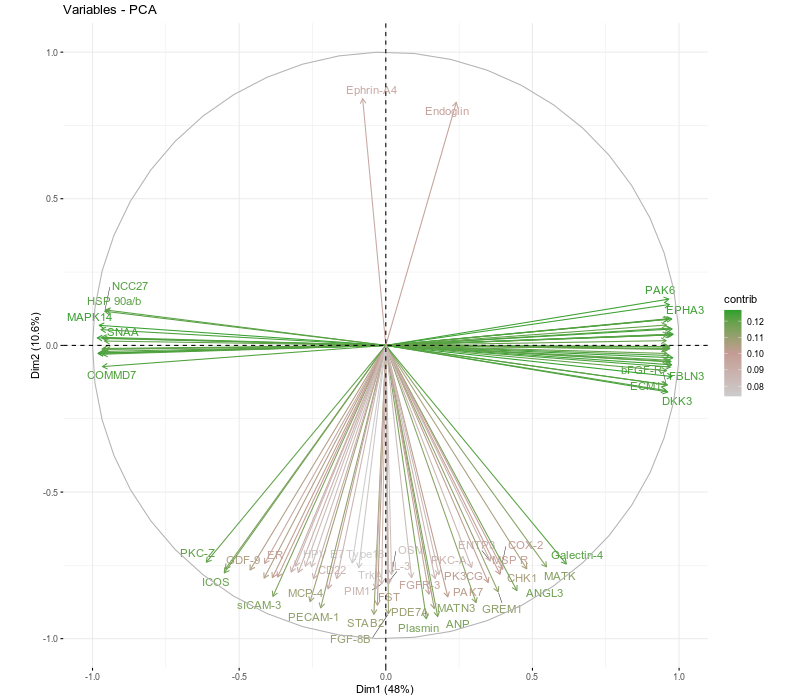

In [49]:
%%R -w 800 -h 700 -u px -i selected_proteins
    fviz_pca_var(
    pca, repel=T,
    col.var="contrib",
    gradient.cols=c("#cccccc", "#c49c94", "#2CA02C"),
    select.var=list(name=selected_proteins)
)

### Increasing interpretability - gene ontology analysis

In [50]:
%%R
small_heatmap = function(matrix) {
    colnames(matrix) <- sub('^X', '', colnames(matrix))
    pheatmap(
        matrix,
        show_colnames=FALSE,
        annotation_col=patient_annotations,
        annotation_colors=patient_colors,
        border_color='grey70',
        scale='row'
    )
}

#### Gene ontology enrichment

I will highlight proteins of genes associated with major biological processes of the cell.

I use Gene Ontology (though it is less specific than let say PRO - a protein ontology) as it is an established standard and "behaves well". I can change it to use another ontology if you wish to proceed with this kind of analyses.

To get curated GO-protein associations for UniProt accessions I use [GOA from EBI](https://www.ebi.ac.uk/GOA).

The Gene Ontology comes from obolibrary.org. Both files can be downloaded using download.sh script.

In [51]:
from goatools.associations import read_gaf
from goatools.obo_parser import GODag

In [52]:
from helpers.ontology import ProteinOntologyClassifier

In [53]:
classifier = ProteinOntologyClassifier(
    ontology=GODag(gene_ontology_path),
    associations=read_gaf(uniprot_to_go_path)
)

data/ontologies/go-basic.obo: fmt(1.2) rel(2019-05-09) 47,407 GO Terms
  READ      479,108 associations: data/ontologies/goa_human.gaf


In [54]:
relevant_aptamers = read_csv(aptamers_path)

# Note: not all aptamers are mapped to UniProt,
# "PODML2 PODML3" are not mapped
assert any(relevant_aptamers.UniProt == 'P0DML2 P0DML3')
relevant_aptamers.UniProt.head(2)

0    P31947
1    P31946
Name: UniProt, dtype: object

In [55]:
processes = classifier.classify(
    index=relevant_aptamers.Target,
    proteins=relevant_aptamers.UniProt,
    parent_term='biological_process'
)

What are the common/rare processes?

As we analyze only a fraction of the proteome, the analyzed proteins may over-represent certain processes.

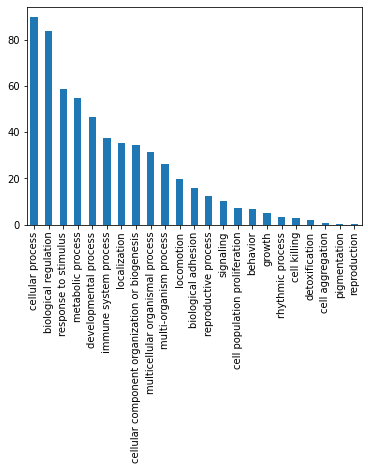

In [56]:
measured_proteins_with_process_ratio = (
    processes.sum() / len(processes) * 100
).sort_values(ascending=False)
measured_proteins_with_process_ratio.plot(kind='bar');

#### Major biological processes

In [57]:
from helpers.ontology import transform_to_classes

In [58]:
processes_matrix = transform_to_classes(zz_log_matrix, processes)

Going to loose signal from 4.52% (59) proteins


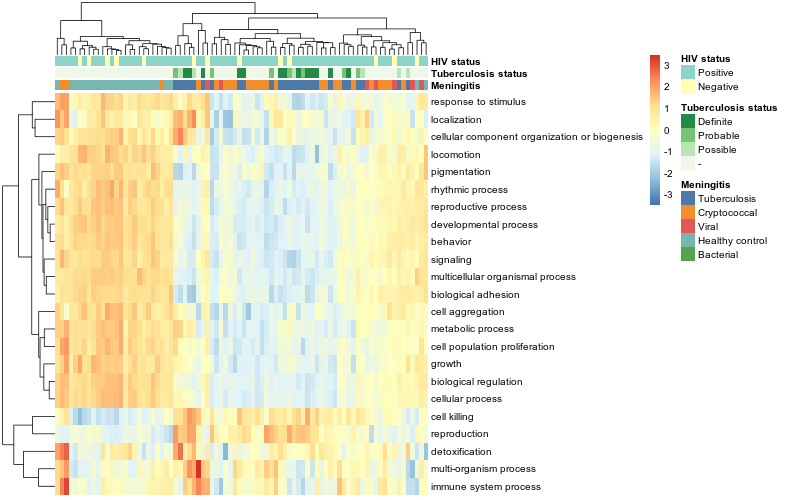

In [59]:
%%R -w 800 -h 500 -u px -i processes_matrix
small_heatmap(processes_matrix)

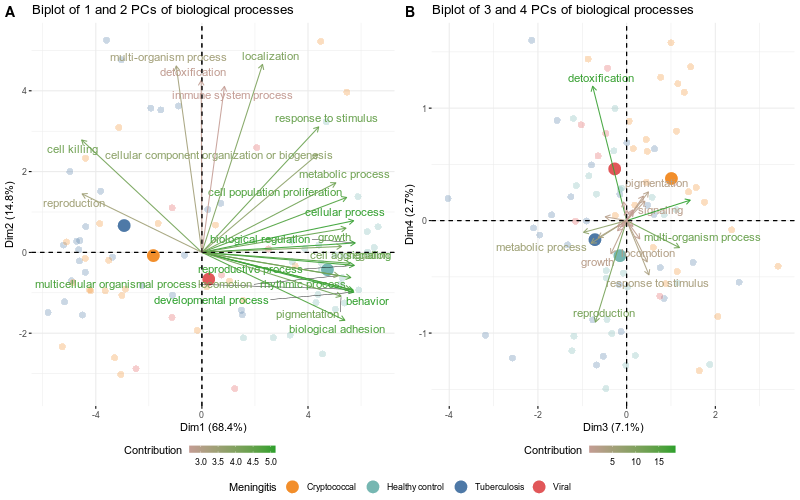

In [60]:
%%R -w 800 -h 500 -u px
first_four_pcs(processes_matrix, 'biological processes')

#### Molecular functions

In [61]:
functions = classifier.classify(
    index=relevant_aptamers.Target,
    proteins=relevant_aptamers.UniProt,
    parent_term='molecular_function'
)
functions_matrix = transform_to_classes(zz_log_matrix, functions)

Going to loose signal from 6.05% (79) proteins


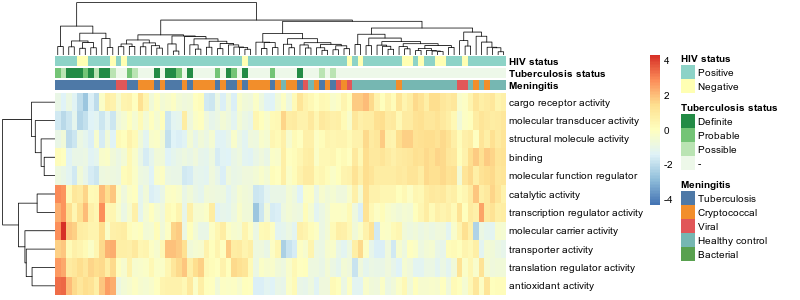

In [62]:
%%R -w 800 -h 300 -u px -i functions_matrix
small_heatmap(functions_matrix)

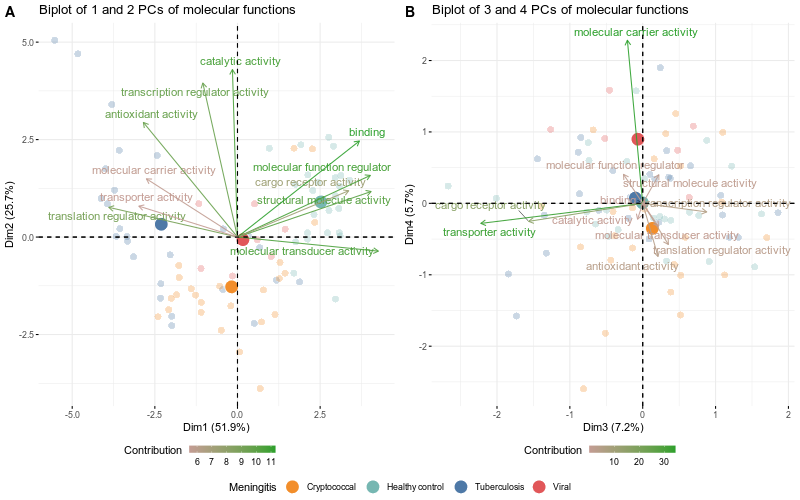

In [63]:
%%R -w 800 -h 500 -u px
first_four_pcs(functions_matrix, 'molecular functions')

#### Cellular components

In [64]:
components = classifier.classify(
    index=relevant_aptamers.Target,
    proteins=relevant_aptamers.UniProt,
    parent_term='cellular_component'
)
components_matrix = transform_to_classes(zz_log_matrix, components)

Going to loose signal from 5.29% (69) proteins


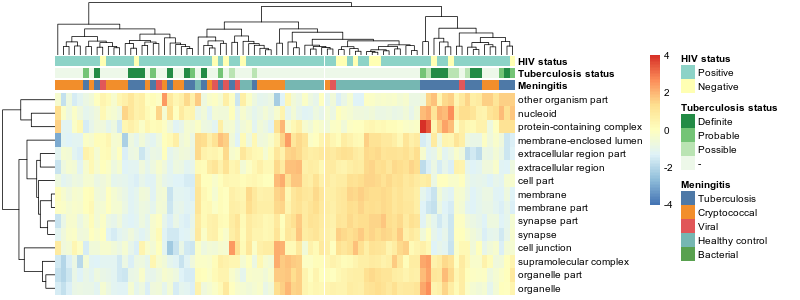

In [65]:
%%R -w 800 -h 300 -u px -i components_matrix
small_heatmap(components_matrix)

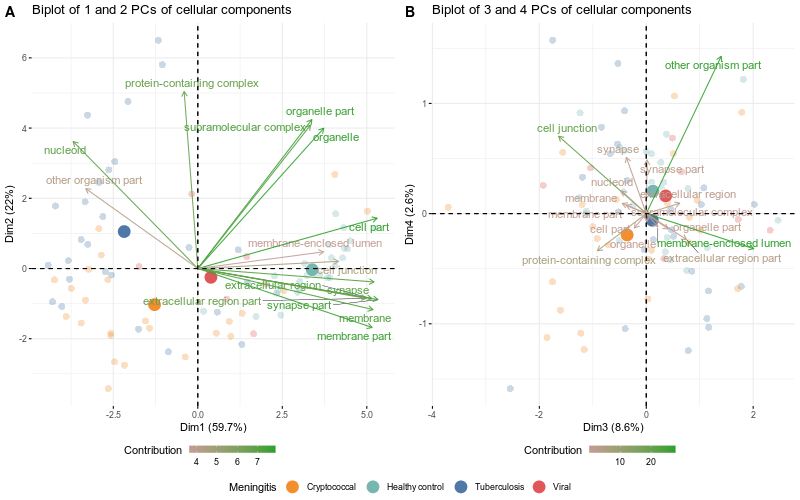

In [66]:
%%R -w 800 -h 500 -u px
first_four_pcs(components_matrix, 'cellular components')

Given little viral proteins and no bacterial proteins (in the SOMAScan array) the presence of nucleoid is a bit surprising. Which proteins are in there?

In [67]:
list(components[components.nucleoid == True].index)

['ATP synthase beta chain']

Just one!

In [68]:
relevant_aptamers.query('Target == "ATP synthase beta chain"').UniProt

234    P06576
Name: UniProt, dtype: object

So here "nucleoid" refers to a region of human mitochondrium!